# Analysis fixed commits in the Linux kernel since 2013

## Business understanding

The Linux kernel is one of the world's largest and complex software projects. The source code consist of more than 25 million lines. A new release is created every two months where each release has 1700 or more contributors from more than 200 different companies as well as volunteers.

The source code is managed in a Git repository. The amount of code changes is huge: "2017 saw 71,552 commits to the Linux kernel tree. That added 3,911,061 lines of new code and 1,385,507 lines of code removed for a net gain of 2.5 million lines." (https://www.phoronix.com/scan.php?page=news_item&px=Linux-Kernel-Commits-2017)

"Patches do not normally pass directly into the mainline kernel; instead, they pass through one of over 100 subsystem trees." (Linux Kernel Report 2017). Here the are reviewed by the subsystem maintainers and stay in the for-next tree for testing.

Despite reviewing and testing bugs pass into the mainline code. Some may just be a nuisance but the number of security critical bugs alone goes into the hundreds (cf. https://www.cvedetails.com/product/47/Linux-Linux-Kernel.html).
 
So it would be of interest to find a classification scheme indicating patches that come with a high risk of creating new bugs.

## Data understanding, part 1

The most accessable data source about the Linux kernel is the Git repository in which the code is prepared. The development of the next release occurs in the mainline tree https://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git. Once a release is finalized further changes can be seen in the stable tree https://git.kernel.org/pub/scm/linux/kernel/git/stable/linux.git.

Changes to be merged into a Git repository often are submitted as a series of patches which together provide the changed functionality. Unfortunately this information is only visible in historic emails.

Each patch changes the content or attributes of a single or multiple files. The changes in each file may refer to a single of multiple regions of consecutive lines. These regions are a referred to as hunks (cf. https://dev.to/etcwilde/git-and-the-interactive-patch-add).

Besides a title line the patch typically has a multi-line commit message detailing the reasoning behind the change. 

The Linux kernel documentation has a style guide for patches (https://www.kernel.org/doc/html/latest/process/submitting-patches.html) which requires additional lines to be added to the commit message prededed by tags like: "Signed-off-by:", "Reported-by:", "Tested-by:", "Reviewed-by:", "Suggested-by:" and "Fixes:".

The "Fixes:" line clearly indicates a prior patch which had a problem. The "Fixes:" line should contain at least the first 12 hexadecimal degits of the commit fixed and the title of the fixed patch.

There may be other indications of an error being fixed like a reference to a CVE. Sometimes references to other patches occur in the middle of a commit message. But classifying these would out of the scope for this project. "Fixes:" is the only indicator pointing uniquely to a problematic patch and easily parasable. "Fixes:" tags can be found for commits since 2013. This is why the further analysis will focus on the years 2013ff.

Further information that is available in patches is the author of the patch, the time of he created the patch, the person that committed the patch to the Linux kernel repository and the time when it was committed.


## Data preparation

Git repositories are stored in a complex way distributed over multiple directories as described in https://git-scm.com/docs/gitrepository-layout. In this form it is not amenable for a data analysis.

A major part of this project therefore was extracting the data in a form that can be easily consumed in Python.

The Git version control software comes with a command "git log" which allows to output infromation about all or a range of patches of a repository in text format.

Within this project a parser for the git log text stream was created, which is available at https://github.com/xypron/gitlog_analyzer. 

This tool was used to extract data for the patches since Jan 1st, 2013 until release v5.2.9 into the following files:

authors.csv describes the authors and commiters of the patches and has the following fields:

* id - number identifying the author
* email_domain - email domain of the author
* commits - number of commits by the author
* committer_hour_xx - number of commits in hour xx of the day
* committer_wday_y - number of commits on the day y of the week (1 = Monday)
* first_commit - Unix timestamp of the first commit by the author
* last_commit - Unix timestamp of the last commit
* patches - number of patches by the authors
* author_hour_xx - number of patches in hour xx of the day
* author_wday_y - number of patches on the day y of the week (1 = Monday)
* first_patch - Unix timestamp of the first patch by the author
* last_patch - Unix timestamp of the last patch
* commit_message_lines - total number of commit lines by the author
* changed_files - total number of changed files by the author
* hunks - total number of changed hungs by the author
* lines_added - total number of lines added by the author
* lines_removed - total number of lines removed by the author

commits.csv describes the commits and has the following fields:

* hash - hash of the commit
* committer_timestamp - timestamp when committed
* committer_wday - weekday when committed
* committer_hour - hour of the day when committed
* author_timestamp - timestamp when the patch was authored
* author_wday - weekday when the patch was authored
* author_hour - hour of the day when the patch was authored
* commit_message_lines - number of lines in the commit message
* signed_offs - number of 'Signed-off-by:' for the commit
* testeds - number of 'Tested-by:' for the commit
* reviews - number of the 'Reviewed-by:' for the commit
* fixes - number of the 'Fixes:' lines in the commit message
* changed_files - number of the files changed by the commit
* hunks - number of the hunks changed by the commit
* lines_added - number of the lines added by the commit
* lines_removed - number of the lines removed by the commit
* fixed - number of patches that fixed this commit
* author_* - author with statistic measures at the time of the commit
* committer_* - committer with statistic measures at the time of the commit

The file authors.csv is not needed for the further analysis as the data for authors an committers at the time a patch was committed is contained in commits.csv.

The target of the tool development was to provide the data such that it contains no duplicate or missing data and that it is easily consumable in Python. So not further data cleansing steps will be done.

## Data understanding, part 2

In book version of the CRISP-DM process building data understanding comes before data preparation. But as described before Git data does not come in any format where we could get insight before preparing the data in a usable way. Now that we have the data in CSV files we can try to find out what it tells us.

After looking at the number of data points let's investigate different parameters that may be indicators that a patch will lead to a bug.

In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt # plotting
import matplotlib.patches as mpatches
import numpy as np
from sklearn.model_selection import train_test_split

# Alternative supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from time import time
%matplotlib inline

### Data source

commits.csv contains information about the Linux kernel commits from 2013-01-01 until relase v5.2.9. The data is compiled with the Gitlog Analyzer available at https://github.com/xypron/gitlog_analyzer.

In [2]:
commits = pd.read_csv('commits.csv')
commits.shape

(454921, 167)

In [3]:
pd.set_option('display.max_columns', 500)
commits.head()

,hash,committer_timestamp,committer_wday,committer_hour,author_timestamp,author_wday,author_hour,commit_message_lines,signed_offs,testeds,reviews,fixes,changed_files,hunks,lines_added,lines_removed,fixed,author_id,author_email_domain,author_commits,author_committer_hour_00,author_committer_hour_01,author_committer_hour_02,author_committer_hour_03,author_committer_hour_04,author_committer_hour_05,author_committer_hour_06,author_committer_hour_07,author_committer_hour_08,author_committer_hour_09,author_committer_hour_10,author_committer_hour_11,author_committer_hour_12,author_committer_hour_13,author_committer_hour_14,author_committer_hour_15,author_committer_hour_16,author_committer_hour_17,author_committer_hour_18,author_committer_hour_19,author_committer_hour_20,author_committer_hour_21,author_committer_hour_22,author_committer_hour_23,author_committer_wday_1,author_committer_wday_2,author_committer_wday_3,author_committer_wday_4,author_committer_wday_5,author_committer_wday_6,author_committer_wday_7,author_first_commit,author_last_commit,author_patches,author_author_hour_00,author_author_hour_01,author_author_hour_02,author_author_hour_03,author_author_hour_04,author_author_hour_05,author_author_hour_06,author_author_hour_07,author_author_hour_08,author_author_hour_09,author_author_hour_10,author_author_hour_11,author_author_hour_12,author_author_hour_13,author_author_hour_14,author_author_hour_15,author_author_hour_16,author_author_hour_17,author_author_hour_18,author_author_hour_19,author_author_hour_20,author_author_hour_21,author_author_hour_22,author_author_hour_23,author_author_wday_1,author_author_wday_2,author_author_wday_3,author_author_wday_4,author_author_wday_5,author_author_wday_6,author_author_wday_7,author_first_patch,author_last_patch,author_commit_message_lines,author_changed_files,author_hunks,author_lines_added,author_lines_removed,committer_id,committer_email_domain,committer_commits,committer_committer_hour_00,committer_committer_hour_01,committer_committer_hour_02,committer_committer_hour_03,committer_committer_hour_04,committer_committer_hour_05,committer_committer_hour_06,committer_committer_hour_07,committer_committer_hour_08,committer_committer_hour_09,committer_committer_hour_10,committer_committer_hour_11,committer_committer_hour_12,committer_committer_hour_13,committer_committer_hour_14,committer_committer_hour_15,committer_committer_hour_16,committer_committer_hour_17,committer_committer_hour_18,committer_committer_hour_19,committer_committer_hour_20,committer_committer_hour_21,committer_committer_hour_22,committer_committer_hour_23,committer_committer_wday_1,committer_committer_wday_2,committer_committer_wday_3,committer_committer_wday_4,committer_committer_wday_5,committer_committer_wday_6,committer_committer_wday_7,committer_first_commit,committer_last_commit,committer_patches,committer_author_hour_00,committer_author_hour_01,committer_author_hour_02,committer_author_hour_03,committer_author_hour_04,committer_author_hour_05,committer_author_hour_06,committer_author_hour_07,committer_author_hour_08,committer_author_hour_09,committer_author_hour_10,committer_author_hour_11,committer_author_hour_12,committer_author_hour_13,committer_author_hour_14,committer_author_hour_15,committer_author_hour_16,committer_author_hour_17,committer_author_hour_18,committer_author_hour_19,committer_author_hour_20,committer_author_hour_21,committer_author_hour_22,committer_author_hour_23,committer_author_wday_1,committer_author_wday_2,committer_author_wday_3,committer_author_wday_4,committer_author_wday_5,committer_author_wday_6,committer_author_wday_7,committer_first_patch,committer_last_patch,committer_commit_message_lines,committer_changed_files,committer_hunks,committer_lines_added,committer_lines_removed
0,e003ae399c160e00c1a882dc6dd4f0ef855ae616,1357041880,2,0,1353669155,5,8,10,2,0,0,0,1,1,2,2,0,10759,gmail.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,1,0,3,1,1,0,2,9,6,27,4,14,1

In [4]:
print("lines added: {}".format(np.sum(commits['lines_added'])))
print("lines removed: {}".format(np.sum(commits['lines_removed'])))

lines added: 27420276
lines removed: 17278976


In [5]:
# Some patches do not change any line but only file attributes.
print("Commits without hunks {}".format(commits[commits['hunks']==0].shape[0]))
print("Thereof fixed {}".format(commits[commits['hunks']==0][commits['fixed']>0].shape[0]))

Commits without hunks 47
Thereof fixed 0


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


### Changes

The Linux kernel v5.2.9 has 26,552,127 lines (https://de.wikipedia.org/wiki/Linux_%28Kernel%29). Since 2013 more lines were deleted than the 2013 kernel contained.

In [6]:
fixed = commits[commits['fixed']>0];
fixed.shape

(22012, 167)

In [7]:
print("Percentage of patches marked as fixed:{:5.2f} %".format(fixed.shape[0] / commits.shape[0] * 100))

Percentage of patches marked as fixed: 4.84 %


### Fixes:

If a patch corrects an error created by a previuous patch the patch may be marked with

    "Fixes: <hash> ("<commit title>")
    
(https://www.kernel.org/doc/html/v4.17/process/submitting-patches.html#using-reported-by-tested-by-reviewed-by-suggested-by-and-fixes)

If a subsequent patch marks a commit as fixed, we can assume that it contained an error. On the other side a commit not being mentioned as fixed does not imply that it was free of errors:

* an error has not yet been discovered
* an error was discovered but was not (yet) fixed, e.g. a minor issue like using %d to print an unsigned integer
* the author of a fix did not bother to mention the fixed patch
* a patch with a 'Fixes:' message may have an invalid format so that the Gitlog Analyzer does not count it (e.g. the hash is too short). This concerns 757 commits since 2013.

### Influence of complexity

It seems natural to assume that the more complex a change is, the more errorprone it is. Let's check.

In [8]:
def hist_side_by_side(title, ds1, ds2, bins, min, max, right_subtitle = 'Fixed commits'):
    """Print two histograms side by side
    
    title          -- title to print above the histograms
    ds1            -- first dataframe
    ds2            -- second data rame
    bins           -- number of histogram bins to be used
    min            -- minimum value of the x-axis
    max            -- maximum value of the x-axis
    right_subtitle -- subtitle of the second histogram
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), squeeze=False)
    fig.tight_layout()
    fig.suptitle(title, fontsize=28, y=1.1)
    
    ax[0][0].title.set_text('All commits')
    ax[0][1].title.set_text(right_subtitle)
    
    ds1.hist(bins=bins, range=(min, max), ax=ax[0][0])
    ds2.hist(bins=bins, range=(min, max), ax=ax[0][1])

    plt.show()

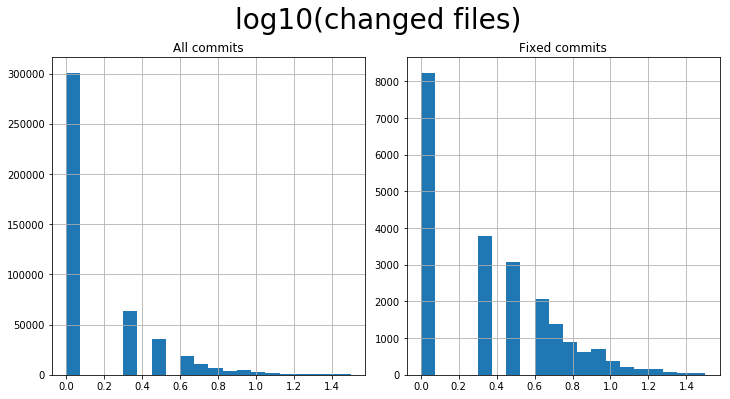

mean number of changed files:
all: 2.2306246579076365
fixed: 3.929129565691441


In [9]:
hist_side_by_side('log10(changed files)',
                  np.log10(commits['changed_files']), np.log10(fixed['changed_files']),
                  20, 0, 1.5)
print("mean number of changed files:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['changed_files']>0]['changed_files']),
      np.mean(fixed[fixed['changed_files']>0]['changed_files'])))

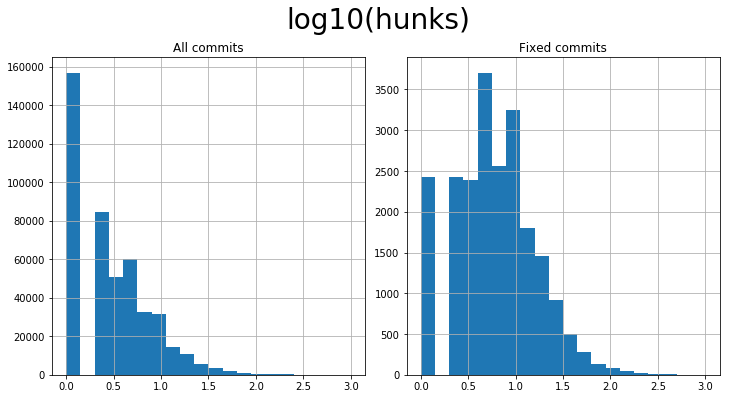

mean number of hunks:
all: 5.20612960951824
fixed: 10.389514810103579


In [10]:
hist_side_by_side('log10(hunks)',
                  np.log10(commits[commits['hunks']>0]['hunks']),
                  np.log10(fixed[fixed['hunks']>0]['hunks']),
                  20, 0, 3)
print("mean number of hunks:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['hunks']>0]['hunks']),
      np.mean(fixed[fixed['hunks']>0]['hunks'])))

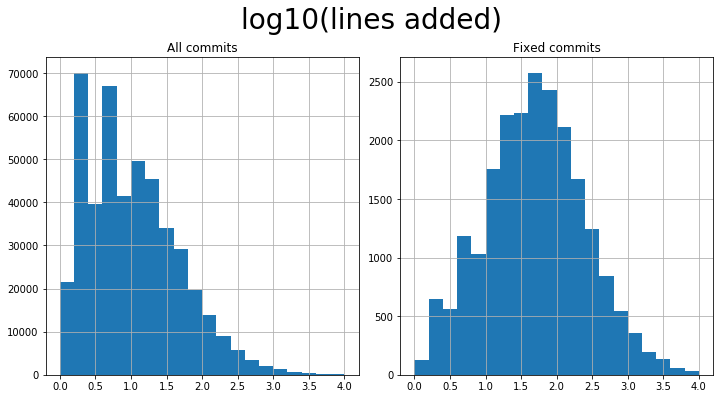

mean number of lines added:
all: 60.28103606713068
fixed: 258.16272942031617


In [11]:
hist_side_by_side('log10(lines added)',
                  np.log10(commits[commits['lines_added']>0]['lines_added']),
                  np.log10(fixed[fixed['lines_added']>0]['lines_added']),
                  20, 0, 4)
print("mean number of lines added:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['lines_added']>0]['lines_added']),
      np.mean(fixed[fixed['lines_added']>0]['lines_added'])))

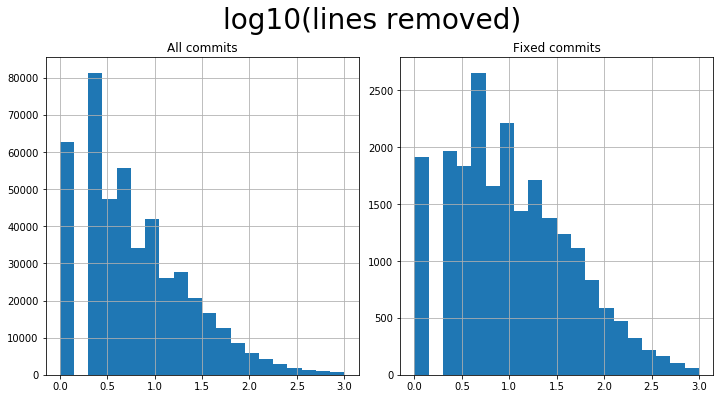

mean number of lines removed:
all: 37.98629070907548
fixed: 67.57759403961475


In [12]:
hist_side_by_side('log10(lines removed)',
                  np.log10(commits[commits['lines_removed']>0]['lines_removed']),
                  np.log10(fixed[fixed['lines_removed']>0]['lines_removed']),
                  20, 0, 3)
print("mean number of lines removed:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['lines_removed']>0]['lines_removed']),
      np.mean(fixed[fixed['lines_removed']>0]['lines_removed'])))

In [13]:
x=commits[commits['hunks']>0]['hunks']
y=commits[commits['hunks']>0]['fixed'] / commits[commits['hunks']>0]['hunks']
print("Correlation coeeficient between hunks and fixed per hunk = {}".format(np.corrcoef(x,y)[0][1]))

Correlation coeeficient between hunks and fixed per hunk = -0.006816371402910087


In [14]:
x=commits[commits['changed_files']>0]['changed_files']
y=commits[commits['changed_files']>0]['fixed'] / commits[commits['changed_files']>0]['changed_files']
print("Correlation coeeficient between files changed and fixed per file = {}".format(np.corrcoef(x,y)[0][1]))

Correlation coeeficient between files changed and fixed per file = -0.0022518978904436243


In [15]:
x=commits[commits['lines_added']>0]['lines_added']
y=commits[commits['lines_added']>0]['fixed'] / commits[commits['lines_added']>0]['lines_added']
print("Correlation coeeficient between lines added and fixed per line added = {}".format(np.corrcoef(x,y)[0][1]))

Correlation coeeficient between lines added and fixed per line added = -0.0036661574048970683


In [16]:
x=commits[commits['lines_removed']>0]['lines_removed']
y=commits[commits['lines_removed']>0]['fixed'] / commits[commits['lines_removed']>0]['lines_removed']
print("Correlation coeeficient between lines removed and fixed per line removed = {}".format(np.corrcoef(x,y)[0][1]))

Correlation coeeficient between lines removed and fixed per line removed = -0.0037118095772214654


The rate of fixes applied per amount of change does not increase with the size of the change.

This contrasts with the often heard advice: "Separate your big patch into smaller ones that can be easily reviewed."

### Influence of the authors experience

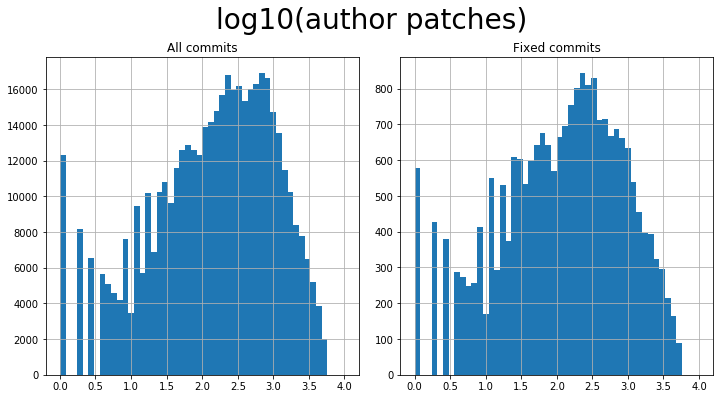

mean number of author patches:
all: 538.1464166305798
fixed: 480.80228966018535


In [17]:
hist_side_by_side('log10(author patches)',
                  np.log10(commits[commits['author_patches']>0]['author_patches']),
                  np.log10(fixed[fixed['author_patches']>0]['author_patches']),
                  50, 0, 4)
print("mean number of author patches:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['author_patches']>0]['author_patches']),
      np.mean(fixed[fixed['author_patches']>0]['author_patches'])))

Correlation coeeficient between log(author patches) and log(hunks) = 0.031596727580444246


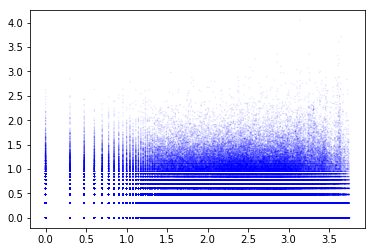

In [18]:

x=np.log10(commits[commits['hunks']>0]['author_patches'])
y=np.log10(commits[commits['hunks']>0]['hunks'])
plt.scatter(x, y, c='blue', alpha=0.1, s=2, edgecolors='none')
print("Correlation coeeficient between log(author patches) and log(hunks) = {}".format(np.corrcoef(x,y)[0][1]))

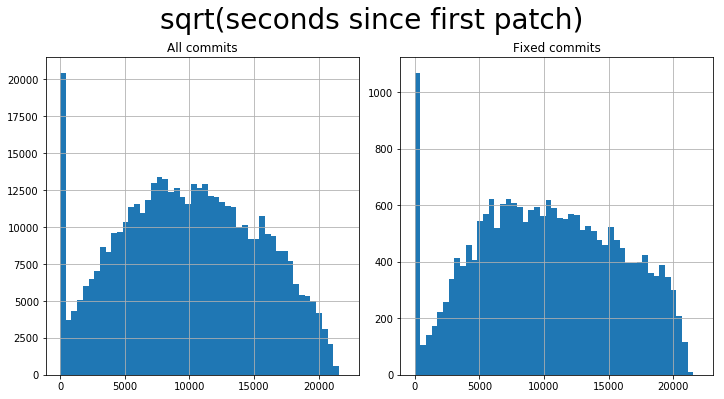

mean years since first patch:
all: 4.04
fixed: 4.28


In [19]:
hist_side_by_side('sqrt(seconds since first patch)',
                  np.sqrt(commits['author_last_patch'] - commits['author_first_patch']),
                  np.sqrt(fixed['author_last_patch'] - fixed['author_first_patch']),
                  50, 0, 22000)

print("mean years since first patch:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['author_last_patch'] - commits['author_first_patch']) / 31557600,
      np.mean(fixed['author_last_patch'] - fixed['author_first_patch']) / 31557600))

Correlation coeeficient between sqrt(seconds since first patch) and log(hunks) = 0.04294182156633916


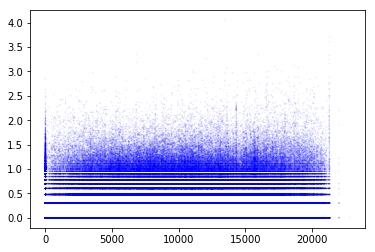

In [20]:
x=np.sqrt(commits[commits['hunks']>0]['author_last_patch'] - commits[commits['hunks']>0]['author_first_patch'])
y=np.log10(commits[commits['hunks']>0]['hunks'])

plt.scatter(x, y, c='blue', alpha=0.1, s=2, edgecolors='none')
print("Correlation coeeficient between sqrt(seconds since first patch) and log(hunks) = {}".format(
    np.corrcoef(x,y)[0][1]))


The percentage of fixed patches decreases a bit with number of patches and increases a bit with the time since the first patch.

### Influence of peer review

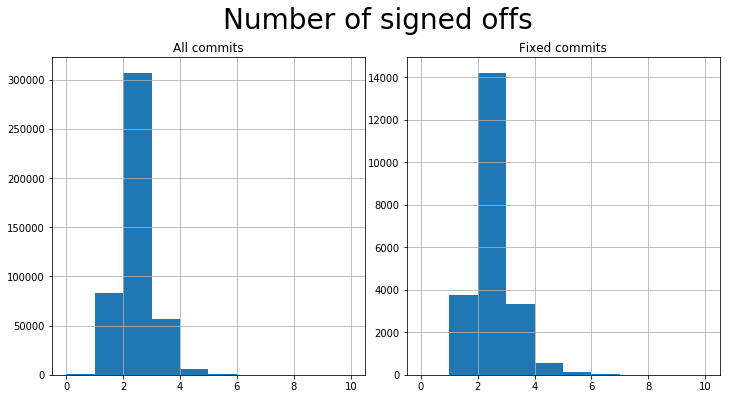

mean number of signed offs:
all: 1.97
fixed: 2.06
Number of signed offs 0, average number of hunks  2.89
Number of signed offs 1, average number of hunks  6.49
Number of signed offs 2, average number of hunks  4.81
Number of signed offs 3, average number of hunks  5.20
Number of signed offs 4, average number of hunks  6.98
Number of signed offs 5, average number of hunks  8.44
Number of signed offs 6, average number of hunks 15.62
Number of signed offs 7, average number of hunks 10.58
Number of signed offs 8, average number of hunks  5.70
Number of signed offs 9, average number of hunks 43.67
Number of signed offs 10, average number of hunks  4.33


In [21]:
hist_side_by_side('Number of signed offs',
                  commits['signed_offs'], fixed['signed_offs'],
                  10, 0, 10)
print("mean number of signed offs:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['signed_offs']), np.mean(fixed['signed_offs'])))

for i in range(0,11):
        print("Number of signed offs {}, average number of hunks {:5.2f}".format(i,
            np.mean(commits[commits['signed_offs']==i]['hunks'])))


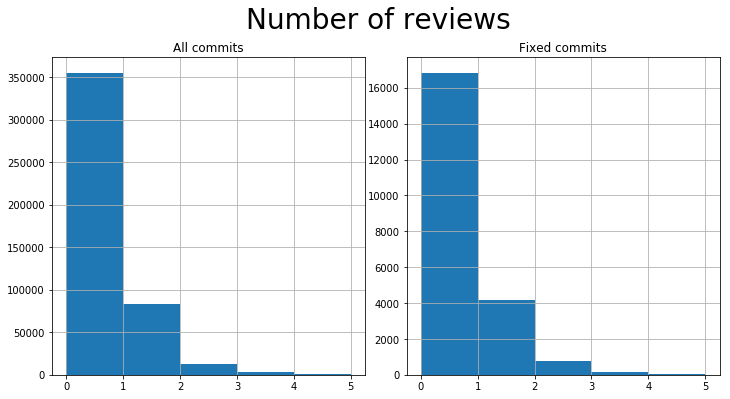

mean number of reviews:
all: 0.27
fixed: 0.29
Number of reviews 0, average number of hunks  5.09
Number of reviews 1, average number of hunks  5.20
Number of reviews 2, average number of hunks  6.06
Number of reviews 3, average number of hunks 13.91
Number of reviews 4, average number of hunks 11.68
Number of reviews 5, average number of hunks  9.03


In [22]:
hist_side_by_side('Number of reviews',
                  commits['reviews'], fixed['reviews'],
                  5, 0, 5)
print("mean number of reviews:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['reviews']), np.mean(fixed['reviews'])))

for i in range(0,6):
        print("Number of reviews {}, average number of hunks {:5.2f}".format(i,
            np.mean(commits[commits['reviews']==i]['hunks'])))

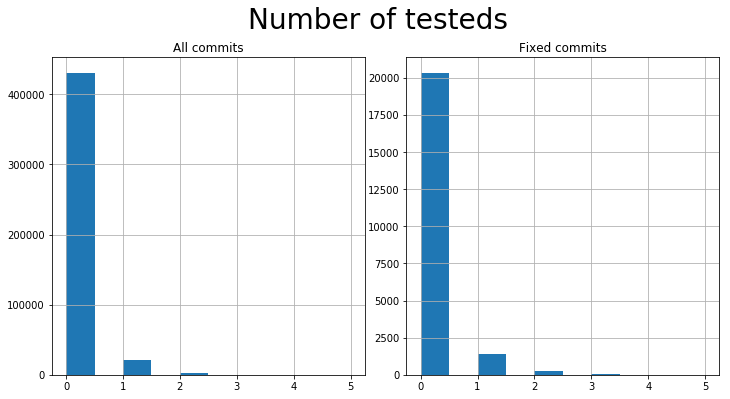

mean number of testeds:
all: 0.06
fixed: 0.09
Number of testeds 0, average number of hunks  5.20
Number of testeds 1, average number of hunks  5.18
Number of testeds 2, average number of hunks  6.32
Number of testeds 3, average number of hunks  6.92
Number of testeds 4, average number of hunks  7.32
Number of testeds 5, average number of hunks  6.35


In [23]:
hist_side_by_side('Number of testeds',
                  commits['testeds'], fixed['testeds'],
                  10, 0, 5)
print("mean number of testeds:\nall: {:4.2f}\nfixed: {:4.2f}".format(
      np.mean(commits['testeds']), np.mean(fixed['testeds'])))

for i in range(0,6):
        print("Number of testeds {}, average number of hunks {:5.2f}".format(i,
            np.mean(commits[commits['testeds']==i]['hunks'])))

The rate of fixed patches increases with the amount of peer review. This reflects that peer review concentrates on complex patches.

Tested patches have a higher percentage of fixed. This may reflect that tester concentrate on what looks 'fishy'.

### Volunteers produce less bugs?
The kernel development is mainly driven by companies only a small proportion is unpaid work: "It was 14.6 percent in the 2012 ..., but is 8.2 percent this time around (ed note 2017)". (2017 State of Linux Kernel Development, https://go.pardot.com/l/6342/2017-10-24/3xr3f2/6342/188781/Publication_LinuxKernelReport_2017.pdf)

An interesting question is if unpaid authors produce more bugs than "professionals".

In [24]:
pd.get_dummies(commits['author_email_domain']).sum().sort_values(ascending=False).head(20)

gmail.com              48205
intel.com              43105
redhat.com             24067
kernel.org             20107
linaro.org             15799
amd.com                11918
ibm.com                11137
samsung.com             9045
ti.com                  7731
google.com              7195
mellanox.com            7047
oracle.com              6838
huawei.com              6376
suse.de                 6287
co.uk                   5727
arm.com                 5103
org.uk                  4779
visionengravers.com     4281
suse.com                3952
renesas.com             3879
dtype: int64

In [25]:
print("Percentage of patches marked as fixed:{:5.2f} %".format(
fixed[fixed['author_email_domain']=='gmail.com'].shape[0] 
    / commits[commits['author_email_domain']=='gmail.com'].shape[0]
    * 100))
print("Mean number of lines added:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['author_email_domain']=='gmail.com']['lines_added']),
      np.mean(fixed[fixed['author_email_domain']=='gmail.com']['lines_added'])))

print("Percentage of patches marked as fixes:{:5.2f} %".format(
      commits[commits['author_email_domain']=='gmail.com']['fixes'].sum() /
      commits[commits['author_email_domain']=='gmail.com'].shape[0] * 100))

Percentage of patches marked as fixed: 3.89 %
Mean number of lines added:
all: 43.04084638522975
fixed: 332.20373333333333
Percentage of patches marked as fixes: 5.85 %


In [26]:
print("Percentage of patches marked as fixed:{:5.2f} %".format(
fixed[fixed['author_email_domain']=='intel.com'].shape[0] 
    / commits[commits['author_email_domain']=='intel.com'].shape[0]
    * 100))
print("Mean number of lines added:\nall: {}\nfixed: {}".format(
      np.mean(commits[commits['author_email_domain']=='intel.com']['lines_added']),
      np.mean(fixed[fixed['author_email_domain']=='intel.com']['lines_added'])))

print("Percentage of patches marked as fixes:{:5.2f} %".format(
      commits[commits['author_email_domain']=='intel.com']['fixes'].sum() /
      commits[commits['author_email_domain']=='intel.com'].shape[0] * 100))

Percentage of patches marked as fixed: 5.69 %
Mean number of lines added:
all: 64.67683563391718
fixed: 304.28239608801954
Percentage of patches marked as fixes: 7.26 %


#### Email domain

The top 20 email domains account for more than half of the commits. Most email domains relate to IT companies. In the top 20 only gmail.com stands out. Let's assume these commits are mostly unpaid work.

At first sight it is astonishing that commits by 'professionals' have a higher fixed rate than those of 'volunteers'. But does that imply that their error rate is higher? Not necessarily. Companies tend to focus their work on the subtrees of the Linux kernel serving their products. If a company has a higher tendency of correctly labeling fixes by a 'Fixes:' line in its sub-trees, this would result in a higher fixed rate in our dataset without implying a higher error rate.

In [27]:
print("hunks per patch, all: {}, gmail.com: {}".format(
    np.mean(commits['hunks']),
    np.mean(commits[commits['author_email_domain']=='gmail.com']['hunks'])))

hunks per patch, all: 5.2055917401043255, gmail.com: 4.568945130173218


In [28]:
print("lines added per patch, all: {}, gmail.com: {}".format(
    np.mean(commits['lines_added']),
    np.mean(commits[commits['author_email_domain']=='gmail.com']['lines_added'])))

lines added per patch, all: 60.27480815350358, gmail.com: 43.04084638522975


gmail.com authors created less compless patches than average.

In [29]:
x=np.mean(commits[commits['hunks']>0]['fixed'] / commits[commits['hunks']>0]['hunks'])
y=np.mean(commits[commits['author_email_domain']=='gmail.com'][commits['hunks']>0]['fixed'] / \
  commits[commits['author_email_domain']=='gmail.com'][commits['hunks']>0]['hunks'])
print("fixed per hunk, all: {}, gmail.com: {}".format(x, y))

fixed per hunk, all: 0.017573075165017146, gmail.com: 0.01607217943234773


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [30]:
x=np.mean(commits[commits['lines_added']>0]['fixed'] / commits[commits['lines_added']>0]['lines_added'])
y=np.mean(commits[commits['author_email_domain']=='gmail.com'][commits['lines_added']>0]['fixed'] / \
  commits[commits['author_email_domain']=='gmail.com'][commits['lines_added']>0]['lines_added'])
print("fixed per lines added, all: {}, gmail.com: {}".format(x, y))

fixed per lines added, all: 0.0036891452586220604, gmail.com: 0.0034544972604665003


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


The smaller fixed rate of gmail.com patches cannot be explained by the by average smaller size of their patches alone as also the number of fixes per patch size is also lower.

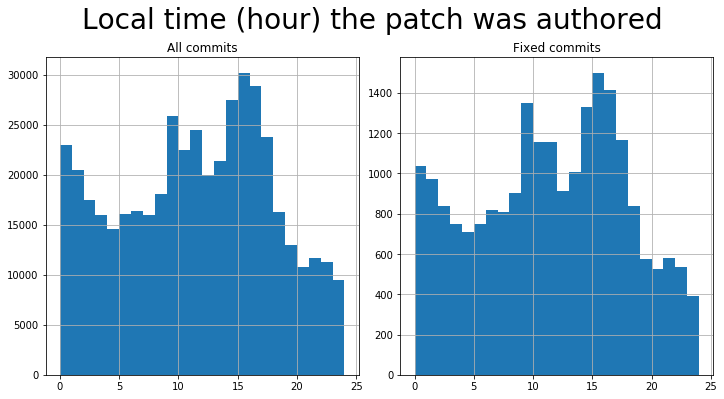

In [31]:
hist_side_by_side('Local time (hour) the patch was authored', commits['author_hour'], fixed['author_hour'], 24, 0, 24)

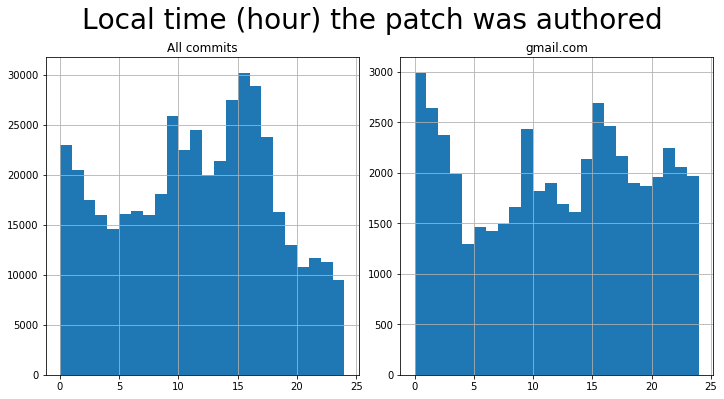

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


wday 0, percentage of Gmail.com commits 13.02 %
wday 1, percentage of Gmail.com commits 12.85 %
wday 2, percentage of Gmail.com commits 13.58 %
wday 3, percentage of Gmail.com commits 12.43 %
wday 4, percentage of Gmail.com commits  8.84 %
wday 5, percentage of Gmail.com commits  9.13 %
wday 6, percentage of Gmail.com commits  8.68 %
wday 7, percentage of Gmail.com commits  9.37 %
wday 8, percentage of Gmail.com commits  9.15 %
wday 9, percentage of Gmail.com commits  9.38 %
wday 10, percentage of Gmail.com commits  8.08 %
wday 11, percentage of Gmail.com commits  7.77 %
wday 12, percentage of Gmail.com commits  8.46 %
wday 13, percentage of Gmail.com commits  7.52 %
wday 14, percentage of Gmail.com commits  7.77 %
wday 15, percentage of Gmail.com commits  8.90 %
wday 16, percentage of Gmail.com commits  8.52 %
wday 17, percentage of Gmail.com commits  9.14 %
wday 18, percentage of Gmail.com commits 11.71 %
wday 19, percentage of Gmail.com commits 14.38 %
wday 20, percentage of Gmail.c

In [32]:
hist_side_by_side('Local time (hour) the patch was authored',
                  commits['author_hour'],
                  commits[commits['author_email_domain']=='gmail.com']['author_hour'], 24, 0, 24, 'gmail.com')

for hour in range(0,24):
    print("wday {}, percentage of Gmail.com commits {:5.2f} %".format(hour, 
            commits[commits['author_hour']==hour][commits['author_email_domain']=='gmail.com'].shape[0] /
            commits[commits['author_hour']==hour].shape[0] * 100))

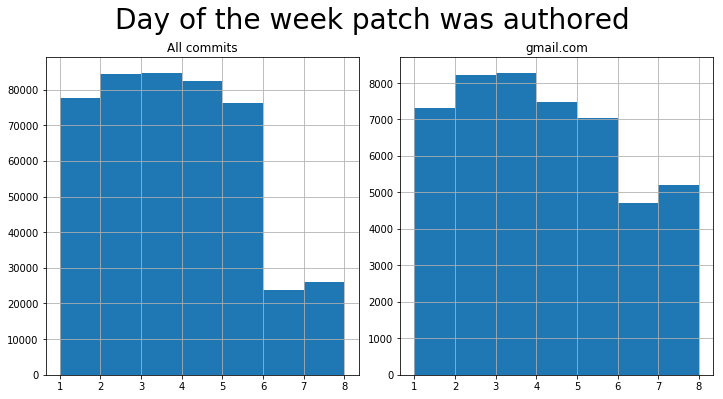

/usr/lib/python3/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


wday 1, percentage of Gmail.com commits  9.41 %
wday 2, percentage of Gmail.com commits  9.73 %
wday 3, percentage of Gmail.com commits  9.77 %
wday 4, percentage of Gmail.com commits  9.08 %
wday 5, percentage of Gmail.com commits  9.22 %
wday 6, percentage of Gmail.com commits 19.78 %
wday 7, percentage of Gmail.com commits 20.08 %


In [33]:
hist_side_by_side('Day of the week patch was authored',
                  commits['author_wday'],
                  commits[commits['author_email_domain']=='gmail.com']['author_wday'], 7, 1, 8, 'gmail.com')

for wday in range(1,8):
    print("wday {}, percentage of Gmail.com commits {:5.2f} %".format(wday, 
            commits[commits['author_wday']==wday][commits['author_email_domain']=='gmail.com'].shape[0] /
            commits[commits['author_wday']==wday].shape[0] * 100))

#### Volunteers working at night and on the weekend
Seeing that the percentage of gmail.com commits is higher on weekends and during the night confirms that this domain comprises a lot of unpaid contributors.

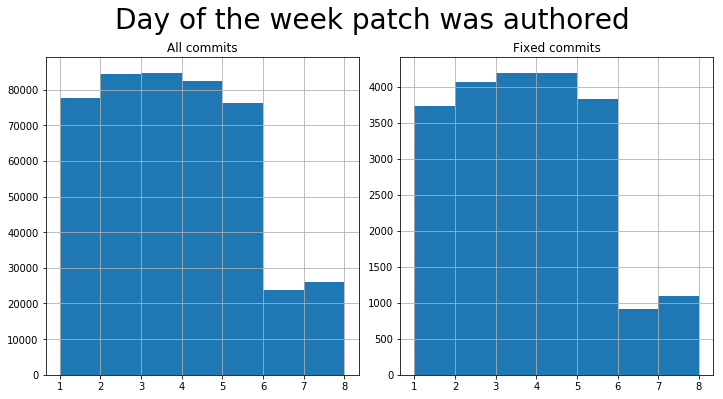

wday 1, fixed percentage  4.81 %
wday 2, fixed percentage  4.82 %
wday 3, fixed percentage  4.95 %
wday 4, fixed percentage  5.08 %
wday 5, fixed percentage  5.03 %
wday 6, fixed percentage  3.83 %
wday 7, fixed percentage  4.22 %


In [34]:
hist_side_by_side('Day of the week patch was authored',
                  commits['author_wday'],fixed['author_wday'], 7, 1, 8)
for wday in range(1,8):
    print("wday {}, fixed percentage {:5.2f} %".format(wday, 
            fixed[fixed['author_wday']==wday].shape[0] /
            commits[commits['author_wday']==wday].shape[0] * 100))

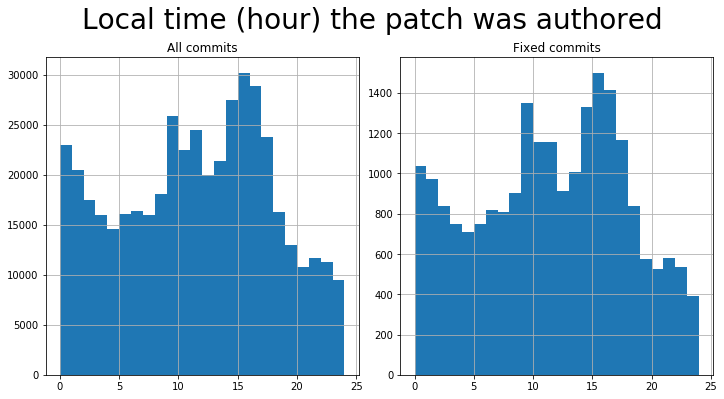

hour 0, fixed percentage  4.51 %
hour 1, fixed percentage  4.74 %
hour 2, fixed percentage  4.80 %
hour 3, fixed percentage  4.67 %
hour 4, fixed percentage  4.84 %
hour 5, fixed percentage  4.67 %
hour 6, fixed percentage  4.99 %
hour 7, fixed percentage  5.07 %
hour 8, fixed percentage  4.99 %
hour 9, fixed percentage  5.21 %
hour 10, fixed percentage  5.13 %
hour 11, fixed percentage  4.73 %
hour 12, fixed percentage  4.58 %
hour 13, fixed percentage  4.71 %
hour 14, fixed percentage  4.84 %
hour 15, fixed percentage  4.97 %
hour 16, fixed percentage  4.89 %
hour 17, fixed percentage  4.91 %
hour 18, fixed percentage  5.17 %
hour 19, fixed percentage  4.41 %
hour 20, fixed percentage  4.86 %
hour 21, fixed percentage  4.95 %
hour 22, fixed percentage  4.73 %
hour 23, fixed percentage  4.15 %


In [35]:
hist_side_by_side('Local time (hour) the patch was authored',
                  commits['author_hour'],
                  fixed['author_hour'], 24, 0, 24)
for hour in range(0,24):
    print("hour {}, fixed percentage {:5.2f} %".format(hour, 
            fixed[fixed['author_hour']==hour].shape[0] /
            commits[commits['author_hour']==hour].shape[0] * 100))

In [36]:
print("Fixed percentage: committed by author {:5.2f} %, committed by other person {:5.2f} %".format(
    fixed[fixed['committer_id']==fixed['author_id']].shape[0]/commits[commits['committer_id']==commits['author_id']].shape[0] * 100,
    fixed[fixed['committer_id']!=fixed['author_id']].shape[0]/commits[commits['committer_id']!=commits['author_id']].shape[0] * 100))

Fixed percentage: committed by author  4.60 %, committed by other person  4.89 %


# Modeling

## Estimator for error rate

Above we have seen that measures of patch complexity correlate with the rate of subsequent fixes. As discussed above the number of 'Fixes:' might be different depending on the preferences of persons working on specific parts of the Linux code. So only those measures will be considered where we would not assume a relationship to the Linux sub-system (dropping email domain, time of work).

In [37]:
def log1(x):
    return [math.log(v) if v > 0 else -1 for v in x]

In [38]:
def nonzero(x):
    return [1 if v > 0 else 0 for v in x]

In [39]:
data = {
    'log_commit_message_lines' : log1(commits['commit_message_lines']),
    'log_signed_offs' : log1(commits['signed_offs']),
    'log_testeds' : log1(commits['testeds']),
    'log_reviews' : log1(commits['reviews']),
    'log_changed_files' : log1(commits['changed_files']),
    'log_hunks' : log1(commits['hunks']),
    'log_lines_added' : log1(commits['lines_added']),
    'log_lines_removed' : log1(commits['lines_removed']),
    'log_author_patches' : log1(commits['author_patches']),
    'author_is_committer' : np.where(commits['author_id'].eq(commits['committer_id']), 1, 0),
    'sqrt_years_experience' : np.sqrt((commits['author_last_patch'] - commits['author_first_patch']) / 31557600),
    'fixed' : nonzero(commits['fixed'])
}
df = pd.DataFrame(data)
x = df.drop(columns='fixed')
y = df['fixed']
df.head()

,log_commit_message_lines,log_signed_offs,log_testeds,log_reviews,log_changed_files,log_hunks,log_lines_added,log_lines_removed,log_author_patches,author_is_committer,sqrt_years_experience,fixed
0,2.302585,0.693147,-1.0,-1.0,0.0,0.000000,0.693147,0.693147,4.828314,0,0.882806,0
1,2.397895,0.693147,-1.0,-1.0,0.0,2.302585,2.772589,2.708050,4.867534,0,1.528699,0
2,2.197225,0.693147,-1.0,-1.0,0.0,0.000000,0.693147,0.693147,2.302585,0,0.770165,0
3,2.197225,0.693147,-1.0,-1.0,0.0,0.000000,0.000000,1.386294,6.291569,0,1.844835,0
4,2.079442,0.693147,-1.0,-1.0,0.0,1.609438,1.791759,4.007333,4.382027,0,1.745163,0


Let's duplicate the fixed commits until they are about 50 % of the records.

In [40]:
df_fixed = df[df['fixed']>0]

In [41]:
print('Number of original records {}'.format(df.shape[0]))
print('Number of records marked as fixed {}'.format(df_fixed.shape[0]))

Number of original records 454921
Number of records marked as fixed 22012


In [42]:
for i in range(0,20):
    df = df.append(df_fixed)

In [43]:
print('Number of records in weighted set {}'.format(df.shape[0]))

Number of records in weighted set 895161


In [44]:
x = df.drop(columns='fixed')
y = df['fixed']
df.head()

,log_commit_message_lines,log_signed_offs,log_testeds,log_reviews,log_changed_files,log_hunks,log_lines_added,log_lines_removed,log_author_patches,author_is_committer,sqrt_years_experience,fixed
0,2.302585,0.693147,-1.0,-1.0,0.0,0.000000,0.693147,0.693147,4.828314,0,0.882806,0
1,2.397895,0.693147,-1.0,-1.0,0.0,2.302585,2.772589,2.708050,4.867534,0,1.528699,0
2,2.197225,0.693147,-1.0,-1.0,0.0,0.000000,0.693147,0.693147,2.302585,0,0.770165,0
3,2.197225,0.693147,-1.0,-1.0,0.0,0.000000,0.000000,1.386294,6.291569,0,1.844835,0
4,2.079442,0.693147,-1.0,-1.0,0.0,1.609438,1.791759,4.007333,4.382027,0,1.745163,0


In [45]:
# Scale the data
scaler = StandardScaler()
x = scaler.fit_transform(x)
pd.DataFrame(x).head()

/usr/lib/python3/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/lib/python3/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6,7,8,9,10
0,-0.758743,0.139555,-0.252038,-0.515832,-0.793057,-1.268061,-1.372410,-0.927193,0.005072,-0.460753,-0.943763
1,-0.584352,0.139555,-0.252038,-0.515832,-0.793057,0.888006,-0.191981,0.422405,0.024470,-0.460753,-0.276004
2,-0.951522,0.139555,-0.252038,-0.515832,-0.793057,-1.268061,-1.372410,-0.927193,-1.244104,-0.460753,-1.060219
3,-0.951522,0.139555,-0.252038,-0.515832,-0.793057,-1.268061,-1.765887,-0.462917,0.728769,-0.460753,0.050835
4,-1.167031,0.139555,-0.252038,-0.515832,-0.793057,0.238965,-0.748765,1.292675,-0.215653,-0.460753,-0.052211


In [46]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: fixed, dtype: int64

In [47]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [48]:
# Calculate accuracy of naive predictor
accuracy = np.sum(y) / len(y)
recall = 1
precision = accuracy

# beta < 1 lends more weight to precision
beta = .5
# fscore = fbeta_score(income, [1] * len(y), beta)
fscore = (1. + beta * beta) * precision * recall / (beta * beta * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5164, F-score: 0.5717]


In [49]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Split of sample_size samples to use for training
    if sample_size < X_train.shape[0]:
        X_use, X_ignore, y_use, y_ignore = train_test_split(X_train, y_train,
                                                            train_size = sample_size, test_size = 0,
                                                            random_state=83615786)
    else:
        X_use = X_train
        y_use = y_train
        
    start = time() # Get start time
    learner.fit(X_use, y_use)
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the training samples(X_train)
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the training samples
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the training samples using fbeta_score()
    beta = .5
    results['f_train'] = fbeta_score(y_train, predictions_train, beta)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
            
    # Return the results
    return results

In [50]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3, figsize = (11,7))
    plt.subplots_adjust(hspace=.35)
    
    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches, bbox_to_anchor = (-.5, 2.7), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

## Selection of classifier models

KNeighbors, SGD are suitable algorithms according to https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html. Not considering SVC due to runtime on large data sets. Adding RandomForest.

KNeighborsClassifier trained on 7161 samples.
KNeighborsClassifier trained on 71612 samples.
KNeighborsClassifier trained on 716128 samples.


/usr/lib/python3/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 7161 samples.
RandomForestClassifier trained on 71612 samples.
RandomForestClassifier trained on 716128 samples.


/usr/lib/python3/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/lib/python3/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier trained on 7161 samples.
SGDClassifier trained on 71612 samples.


/usr/lib/python3/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier trained on 716128 samples.


/usr/lib/python3/dist-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


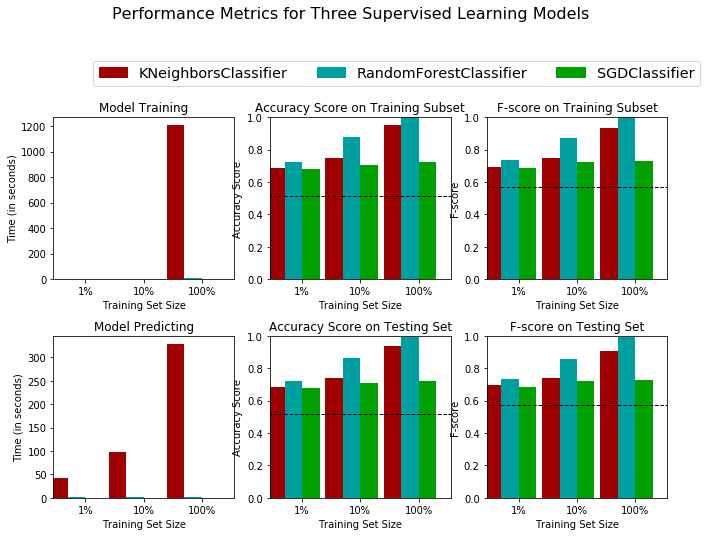

In [51]:
# Initialize the three models
clf_A = KNeighborsClassifier()
clf_B = RandomForestClassifier(random_state=9793)
clf_C = SGDClassifier(random_state=9793)

# Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(samples_100 / 10)
samples_1 = int(samples_100 / 100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
evaluate(results, accuracy, fscore)



/usr/lib/python3/dist-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


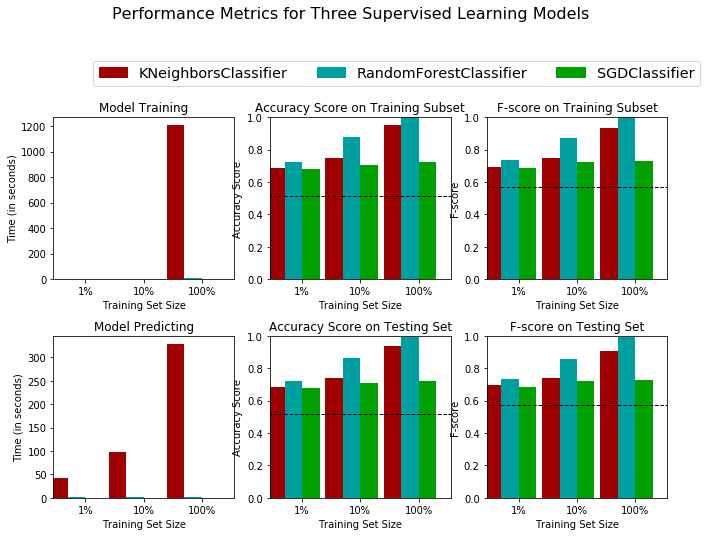

In [52]:

evaluate(results, accuracy, fscore)

In [53]:
results

{'KNeighborsClassifier': {0: {'train_time': 0.025503158569335938,
   'pred_time': 43.15407991409302,
   'acc_train': 0.6861385115510077,
   'acc_test': 0.6850133774220395,
   'f_train': 0.6959012505726879,
   'f_test': 0.6941101568230165},
  1: {'train_time': 3.203774929046631,
   'pred_time': 97.47345232963562,
   'acc_train': 0.7481944568568748,
   'acc_test': 0.7400088251886524,
   'f_train': 0.7455154808297012,
   'f_test': 0.7378074114716587},
  2: {'train_time': 1208.1894133090973,
   'pred_time': 329.33947706222534,
   'acc_train': 0.9540850239063408,
   'acc_test': 0.9353024302782169,
   'f_train': 0.9337918188764932,
   'f_test': 0.9089906167566641}},
 'RandomForestClassifier': {0: {'train_time': 0.08418846130371094,
   'pred_time': 0.9147021770477295,
   'acc_train': 0.7212830667143304,
   'acc_test': 0.719169091731692,
   'f_train': 0.7351005216592397,
   'f_test': 0.7324707231556211},
  1: {'train_time': 0.7062346935272217,
   'pred_time': 1.347839593887329,
   'acc_train':

In [54]:
y_pred = clf_B.predict(X_test)
print("number of test samples {}".format(X_test.shape[0]))
print("confusion matrix")
confusion_matrix(y_test, y_pred)

number of test samples 179033
confusion matrix


array([[85717,   989],
       [   22, 92305]])

In [55]:
df = pd.DataFrame(data)
x = df.drop(columns='fixed')
x = scaler.transform(x)
y = df['fixed']


/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
y_pred = clf_B.predict(x)

In [57]:
print("confusion matrix for original data set")
confusion_matrix(y, y_pred)

confusion matrix for original data set


array([[431620,   1289],
       [     4,  22008]])

# Evaluation

Of the different classifiers compared a Random Forest classifier seems to be most appropriate: It provides the best accuracy and has an acceptable training and prediction time.

The number of false negatives (fixed patches not predicted to need fixing) is so small that further parameter optimization does not make much sense. On the other side we know that there are patches that are not correctly labeled as fixed: they might be too new to be fixed, the "Fixes:" label may not have been correctly filled (757 cases as mentioned above) or not "Fixes:" label may have been applied at all. So opimizing for less "false positives" does also not seem reasonable.

# Deployment

A blog describing the results was created and is available at https://www.xpyron.de/blog